In [9]:
!pip install timm
!pip install h5py

     |████████████████████████████████| 4.1 MB 35.5 MB/s eta 0:00:01


In [3]:
# Imports, midas loading
import cv2
import torch
import urllib.request
import os
import numpy as np
import json

import matplotlib.pyplot as plt

midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.default_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master
Downloading: "https://github.com/intel-isl/MiDaS/releases/download/v2_1/model-f6b98070.pt" to /root/.cache/torch/hub/checkpoints/model-f6b98070.pt


  0%|          | 0.00/403M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [6]:
# get images
LOAD_HYPER = False
if LOAD_HYPER:
    import glob
    dir_path = "ml-hypersim/contrib/99991/downloads/"
    im_examples = sorted(glob.glob(f"{dir_path}/*/*/*/*.jpg"))
    depth_examples = [path.replace(".color.jpg", ".depth_meters.hdf5").replace("scene_cam_00_final_preview", "scene_cam_00_geometry_hdf5") for path in im_examples]
    examples = zip(im_examples, depth_examples)
    examples = [example for example in examples if os.path.exists(example[0]) and os.path.exists(example[1])]
    im1_path, im1_depth = examples[11]
else:
#     dir_path = "Downloads/cloud_renders_multicam_9/"
    dir_path = "renders_multicam_diff_1/"
    examples = sorted([os.path.join(dir_path, x) for x in set(["_".join(path.split("_")[:2]) for path in os.listdir(dir_path)])])
    dirname = examples[1]
    im1_path = f"{dirname}_cam-1_change-0.png"
    im1_depth = f"{dirname}_cam-1_change-0-depth0001.exr"

In [7]:
im1_path, im1_depth

('renders_multicam_diff_1/circ.us.0000_0017c0b964c2492db349f0591c6af20a_cam-1_change-0.png',
 'renders_multicam_diff_1/circ.us.0000_0017c0b964c2492db349f0591c6af20a_cam-1_change-0-depth0001.exr')

In [10]:
import h5py

def load_hdf5(path):
    with h5py.File(path, "r") as f:
        a_group_key = list(f.keys())[0]
        # Get the data
        data = list(f[a_group_key])
        data = np.array(data, np.float32).reshape((768, 1024, 1))
        return data

In [11]:
# Run midas over image
filename = im1_path
depth_filename = im1_depth
print(depth_filename)

img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
if ".hdf5" in im1_depth:
    depth_image = load_hdf5(im1_depth)
    depth_image = depth_image[:, :, 0]
else:
    depth_image = cv2.imread(depth_filename,  cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    depth_image = depth_image[:, :, 0]
depth_image[depth_image>100] = -1
depth_image[depth_image==-1] = np.max(depth_image)
print("depth_image", depth_image.shape)
print("img", img.shape)
input_batch = transform(img).to(device)

with torch.no_grad():
    prediction = midas(input_batch)

    prediction_inter = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="nearest",
#         align_corners=True,
    ).squeeze()
    
rel_depth_pred = prediction_inter.cpu().numpy()

renders_multicam_diff_1/circ.us.0000_0017c0b964c2492db349f0591c6af20a_cam-1_change-0-depth0001.exr
depth_image (720, 1280)
img (720, 1280, 3)


In [12]:
if LOAD_HYPER:
    intrinsic_matrix = np.array(
    [
                [
                    935.30,
                    0.0,
                    1024/2,
                ],
                [
                    0.0,
                    665.11,
                    720/2,
                ],
                [
                    0.0,
                    0.0,
                    1.0,
                ],
            ])
#     intrinsic_matrix[1, 1] = intrinsic_matrix[0, 0]
    IMAGE_WIDTH, IMAGE_HEIGHT = 1024, 764
else:
    cam_param_path = im1_path.replace(".png", "_label.json")
    data = json.load(open(cam_param_path, "r"))
    cam_pos = data['cam_params']['blender_data']['cam_position']
    R = np.array(data['cam_params']['extrinsic'])[:3, :3]
    R[1:3] *= -1
    t = - R.dot(cam_pos)
    K = np.array(data['cam_params']['intrinsic'])
    K[1][1] = K[0][0]
    intrinsic_matrix = K
#     intrinsic_matrix = np.array(
#     [
#                 [
#                     2118.85498046875,
#                     0.0,
#                     1224.0,
#                 ],
#                 [
#                     0.0,
#                     1789.082275390625,
#                     689.0,
#                 ],
#                 [
#                     0.0,
#                     0.0,
#                     1.0,
#                 ],
#             ])
#     intrinsic_matrix[1, 1] = intrinsic_matrix[0, 0]
#     IMAGE_WIDTH, IMAGE_HEIGHT = 2048, 1378
    IMAGE_WIDTH, IMAGE_HEIGHT = 1280, 720

In [13]:
inverse_intrinsic = np.linalg.inv(intrinsic_matrix)
u_v_scale_factors = np.ones_like(depth_image)
for u in range(depth_image.shape[1]):
    for v in range(depth_image.shape[0]):
        u_v_scale_factors[v, u] = np.linalg.norm(inverse_intrinsic.dot([u, v, 1]))

In [21]:
# Convert ground truth distance-to-camera depth into z-depth
if not LOAD_HYPER:
#     depth_image_z_coord = depth_image * 1.0/u_v_scale_factors
    depth_image_z_coord = depth_image
else:
    depth_image_z_coord = depth_image
    depth_image = depth_image * 1.0/u_v_scale_factors

In [22]:
# Perform LEAST SQUARES scaling
d = rel_depth_pred.reshape(-1)
d = np.array([d, np.ones_like(d)]).T
s, t = np.linalg.pinv(d.T.dot(d)).dot(d.T).dot(1 / depth_image_z_coord.reshape(-1))
abs_depth_pred = 1 / (s * rel_depth_pred + t)

In [23]:
# Convert predicted z-depth into distance-to-camera depth
abs_depth_pred = abs_depth_pred * u_v_scale_factors

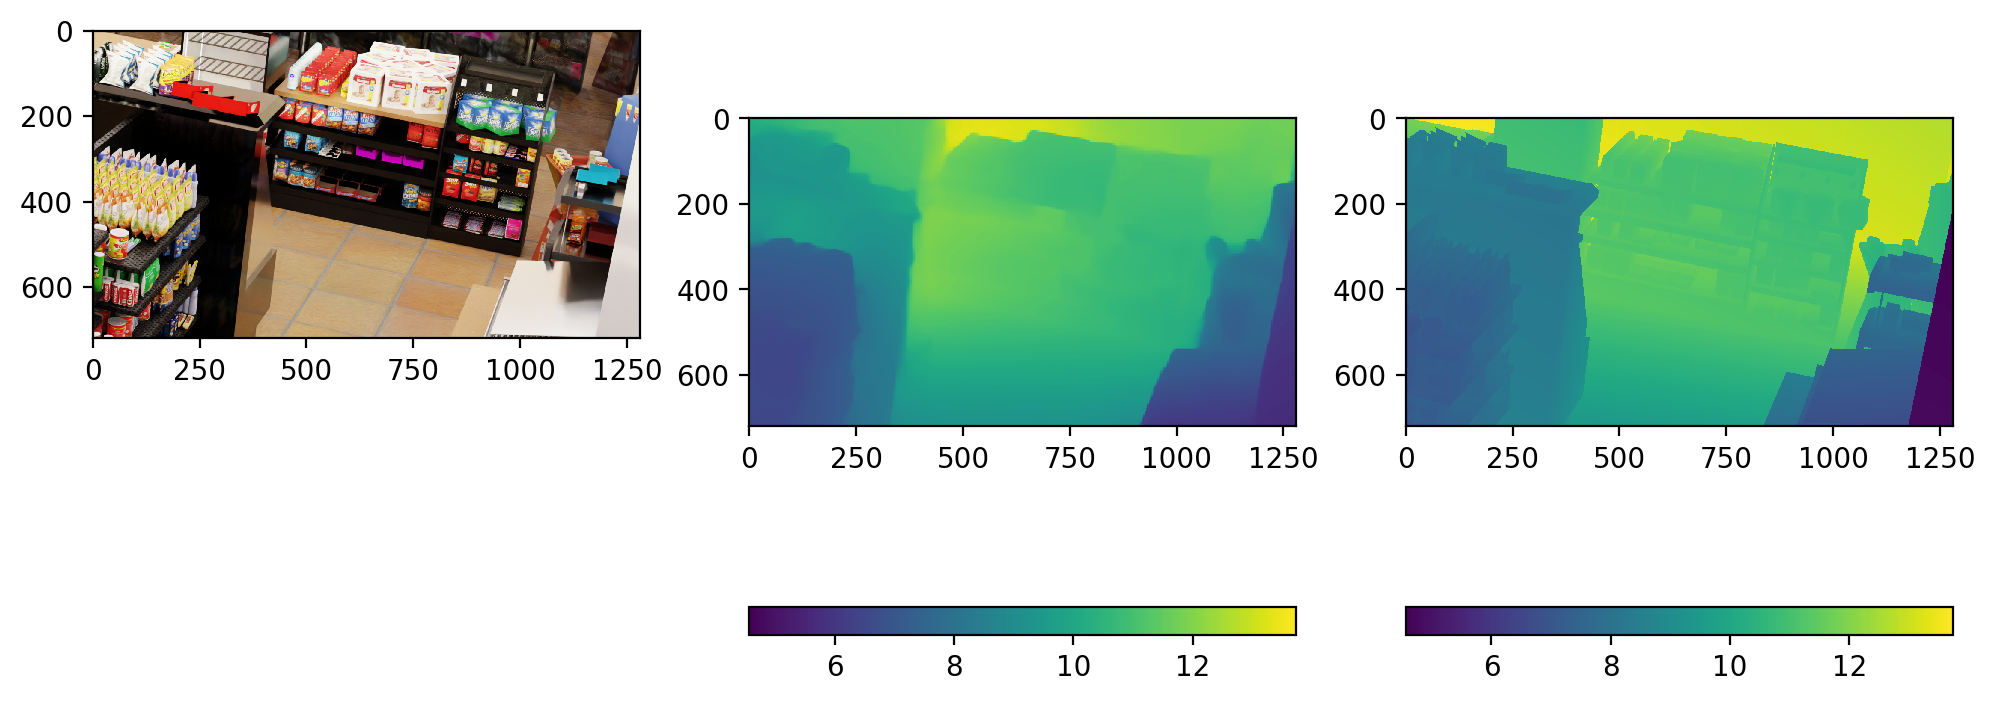

In [24]:
%matplotlib inline
import numpy as np
fig= plt.figure(figsize=(12,8), dpi=200, facecolor='w', edgecolor='k')
fig.tight_layout()
fig.add_subplot(1,3,1)
plt.imshow(img)
fig.add_subplot(1,3,2)
imgplt = plt.imshow(abs_depth_pred, interpolation='none', alpha=1.0)
plt.colorbar(orientation='horizontal')
imgplt.set_clim(np.min(depth_image), np.max(depth_image))
fig.add_subplot(1,3,3)
imgplt = plt.imshow(depth_image, interpolation='none')
plt.colorbar(orientation='horizontal')
plt.show()
# plt.savefig(fname=f"midas_out/{filename.split('/')[-1].replace('.jpg', '.png')}")

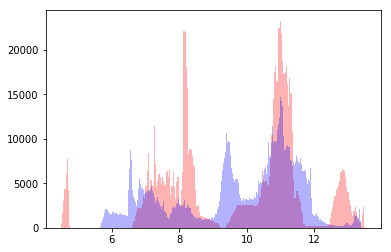

In [25]:
# _ = plt.hist(depth_image.ravel(), bins = 256, color = 'orange', alpha = 0.3)
_ = plt.hist(depth_image_z_coord.ravel(), bins = 256, color = 'red', alpha = 0.3)
_ = plt.hist(abs_depth_pred.ravel(), bins = 256, color = 'blue', alpha = 0.3)

In [26]:
import open3d as o3d
fx, fy = intrinsic_matrix[0][0], intrinsic_matrix[1][1]
cx, cy = intrinsic_matrix[0][2], intrinsic_matrix[1][2]
pinhole_cam = o3d.open3d.camera.PinholeCameraIntrinsic(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, cx=cx,cy=cy,fx=fx, fy=fy)

depth_o3d = o3d.geometry.Image(np.array(depth_image, np.float32))
depth_o3d_pred = o3d.geometry.Image(np.array(abs_depth_pred, np.float32))
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(np.array(img)), depth_o3d, depth_scale=1000.0, depth_trunc=100000.0, convert_rgb_to_intensity=False)
rgbd_pred = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(np.array(img)), depth_o3d_pred, depth_scale=1000.0, depth_trunc=100000.0, convert_rgb_to_intensity=False)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, pinhole_cam)
pcd_pred = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_pred, pinhole_cam)
# pcd = o3d.geometry.PointCloud.create_from_depth_image(depth_o3d, pinhole_cam)

# flip the orientation, so it looks upright, not upside-down
pcd.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
pcd_pred.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])

# pcd.clear()
o3d.io.write_point_cloud("test_cloud.ply", pcd)
o3d.io.write_point_cloud("test_cloud_pred.ply", pcd_pred)

# o3d.visualization.draw_geometries([pcd])    # visualize the point cloud

True